# Hidden Markov Model (HMM)

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath('..'))


from datasets.em_gaussian import EMGaussianDataset
from src.utils.plot import plot_clusters, plot_ellipses
from src.hidden_markov_model import HiddenMarkovModel
from src.mixture_model import MixtureModel

import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
x_train = EMGaussianDataset("../datasets/data/EMGaussian",train=True)[0]
x_test = EMGaussianDataset("../datasets/data/EMGaussian",train=False)[0]

hmm.pi
 [1.00000000e+00 1.76609759e-88 4.26821637e-35 1.74408783e-24]
hmm.transition_matrix
 [[0.89480149 0.03238569 0.03463092 0.06300901]
 [0.07242213 0.02259986 0.0486449  0.88110071]
 [0.01986369 0.01266212 0.88601155 0.03991151]
 [0.00678712 0.92647286 0.03936421 0.01576437]]
hmm.means
 [[-2.97260299 -3.4495834 ]
 [ 3.99372807  3.5909582 ]
 [ 3.78946636 -3.99316394]
 [-1.94806198  4.1944515 ]]
hmm.covariances
 [[[ 6.78104014  6.55761043]
  [ 6.55761043  6.65919358]]

 [[ 0.19778178  0.26502381]
  [ 0.26502381 12.51324635]]

 [[ 0.95271103  0.0649532 ]
  [ 0.0649532   1.52429549]]

 [[ 3.29341253  0.30321368]
  [ 0.30321368  2.82804701]]]


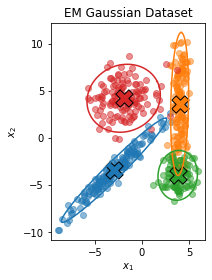

In [3]:
hmm = HiddenMarkovModel(k=4, seed=10)
hmm.initialize(x_train)
likelihoods_train, likelihoods_test = hmm.train(x_train, x_test, likelihood = True)
print("hmm.pi\n", torch.exp(hmm.pi_log).detach().numpy())
print("hmm.transition_matrix\n", torch.exp(hmm.transition_matrix_log).detach().numpy())
print("hmm.means\n", hmm.distribution.means.detach().numpy())
print("hmm.covariances\n", hmm.distribution.covariances.detach().numpy())

plot_ellipses(hmm.distribution)
hmm.distribution.predict = lambda a: hmm.predict(a)
plot_clusters(hmm.distribution, x_train)
plt.show()

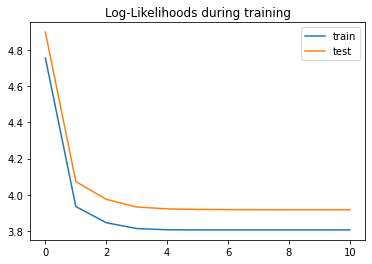

In [4]:
plt.plot(likelihoods_train, label="train")
plt.plot(likelihoods_test, label="test")
plt.legend(loc="best")
plt.title("Log-Likelihoods during training")
plt.show()

In [5]:
from src.distributions import GaussianDistribution
from functools import partial

def get_mll(models):
    data=[]
    for model_name, model_dict in models.items():
        for distribution, model in model_dict.items():
            model.initialize(x_train)
            model.train(x_train)
            data.append([
                model_name,
                distribution,
                model.normalized_negative_marginal_log_likelihood(x_train).item(),
                model.normalized_negative_marginal_log_likelihood(x_test).item()
            ])
    column_names=["model", "distribution", "train", "test"]
    return data, column_names


isotropic_gaussian = partial(GaussianDistribution, covariance_type='isotropic')
models = {
    "mixture_model":{
        "isotropic_gaussian":MixtureModel(4, distribution_type=isotropic_gaussian),
        "full_gaussian":MixtureModel(4),
    },
    "hidden_markov_model":{
        "isotropic_gaussian":HiddenMarkovModel(4, distribution_type=isotropic_gaussian),
        "full_gaussian":HiddenMarkovModel(4),
    }
}

data, column_names = get_mll(models)
pd.DataFrame(data, columns=column_names).round(2)

,model,distribution,train,test
0,mixture_model,isotropic_gaussian,5.35,5.36
1,mixture_model,full_gaussian,4.67,4.86
2,hidden_markov_model,isotropic_gaussian,4.64,4.50
3,hidden_markov_model,full_gaussian,3.83,3.90
